# Titanic Competition

Forked from excellent karnel bellow
- https://github.com/taruto1215/Kaggle_Titanic/blob/master/RF_score_80.9%25-best_model.ipynb
- https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial
- https://qiita.com/FukuharaYohei/items/c87f61aee2a24466d5d4

In [9]:
# あらゆるモデルをインポートしとく
# %%time
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, plot_roc_curve, plot_confusion_matrix

import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder


# from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

path = "C:/***********************/data/"

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
df = pd.concat([df_train, df_test]).reset_index(drop=True)  # 良くないらしい？けどめんどいので統合して扱う

In [10]:
# 提出用時の処理が滞らないように
df = df.rename(columns={'Perished' : 'Survived'})

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


## データの前処理

### 欠損値補完と特徴量生成

#### Fare

In [12]:
# 欠損値の確認
df[df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [13]:
# Fare は Pclass と強い相関があるので、Pclass３の中の平均で補完
print('All average:',df.Fare.mean())
print(df.groupby(['Pclass'])['Fare'].mean())
df['Fare'].fillna(df.groupby(['Pclass'])['Fare'].mean()[3], inplace=True)

All average: 33.2954792813456
Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64


#### Embarked

In [14]:
df.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [15]:
# 最頻値で補完
df['Embarked'] = df['Embarked'].fillna('S')

#### Cabin

![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)

In [16]:
df.Cabin.isnull().sum()

1014

In [17]:
# Deck列にアルファベット部分の抽出
# df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

# 生存率ごとにグルーピング -> やると下がった...
# df['Deck'] = df['Deck'].replace(['A', 'B', 'C'], 'ABC')
# df['Deck'] = df['Deck'].replace(['D', 'E'], 'DE')
# df['Deck'] = df['Deck'].replace(['F', 'G'], 'FG')

# df.groupby('Deck')['Survived'].mean()

# idx = df[df['Deck'] == 'T'].index
# df.loc[idx, 'Deck'] = 'ABC'

# df['Deck'].value_counts()

In [18]:
# アルファベット部分の抽出
df['Cabin'].map(lambda x: str(x)[0])
for i in range(len(df)):
    if df['Cabin'].isnull()[i] == False:
        df['Cabin'][i] = str(df['Cabin'].values[i])[0]

In [19]:
# Cabin のデータが残っている人は生存率が高いので良い特徴量になるかも
df['IsCabin'] = df['Cabin'].isnull().astype(np.int64)  # これで勝手に０か１にしてくれるのね
df.groupby('IsCabin')['Survived'].mean()

IsCabin
0    0.333333
1    0.700146
Name: Survived, dtype: float64

#### Name

In [20]:
# 敬称の列を追加し分類する df.reset_index()してなくて最初うまくいかなかった
# Dr, RevはNullがほぼないので実際は考えなくてok
df['Title'] = 'Other'
for i in range(len(df)):
    if 'Mr.' in df['Name'][i]:
        df['Title'][i] = 'Mr'
    elif 'Mrs.' in df['Name'][i]:
        df['Title'][i] = 'Mrs'
    elif 'Miss.' in df['Name'][i]:
        df['Title'][i] = 'Miss'
    elif 'Master.' in df['Name'][i]:
        df['Title'][i] = 'Master'
    # elif 'Dr.' in df['Name'][i]:
    #     df['Title'][i] = 'Dr'
    # elif 'Rev.' in df['Name'][i]:
    #     df['Title'][i] = 'Rev'
    
# 残りの敬称は少ないので消した
#     Title
# Other      18
# Dr          8
# Master     61
# Miss      260
# Mr        757
# Mrs       197
# Rev         8

Title
Master     61
Miss      260
Mr        757
Mrs       197
Other      34
Name: Age, dtype: int64 



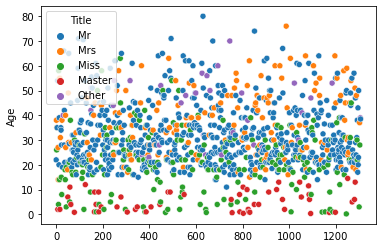

In [21]:
# 敬称ごとの人数と分布
x = list(range(len(df)))
y = df['Age']
sns.scatterplot(x=x, y=y, hue=df['Title'])
print(df.groupby(['Title'])['Age'].size(), '\n')

#### Age

In [22]:
print(df.groupby(['Title'])['Age'].mean())

Title
Master     5.482642
Miss      21.774238
Mr        32.252151
Mrs       36.994118
Other     42.656250
Name: Age, dtype: float64


In [23]:
# 各敬称ごとの年齢の平均値を欠損値に代入
df.loc[(df["Age"].isnull()) & (df["Title"]=='Mr'), "Age"] = df.groupby(['Title'])['Age'].mean()['Mr']
df.loc[(df["Age"].isnull()) & (df["Title"]=='Mrs'), "Age"] = df.groupby(['Title'])['Age'].mean()['Mrs']
df.loc[(df["Age"].isnull()) & (df["Title"]=='Miss'), "Age"] = df.groupby(['Title'])['Age'].mean()['Miss']
df.loc[(df["Age"].isnull()) & (df["Title"]=='Master'), "Age"] = df.groupby(['Title'])['Age'].mean()['Master']
df.loc[(df["Age"].isnull()), "Age"] = df.groupby(['Title'])['Age'].mean()[0]

#### Family size

https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial
のアイデアを参考にした

* Family Size with **1** are labeled as **Alone**
* Family Size with **2**, **3** and **4** are labeled as **Small**
* Family Size with **5** and **6** are labeled as **Medium**
* Family Size with **7**, **8** and **11** are labeled as **Large**

In [24]:
# 自分を含めて＋１
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

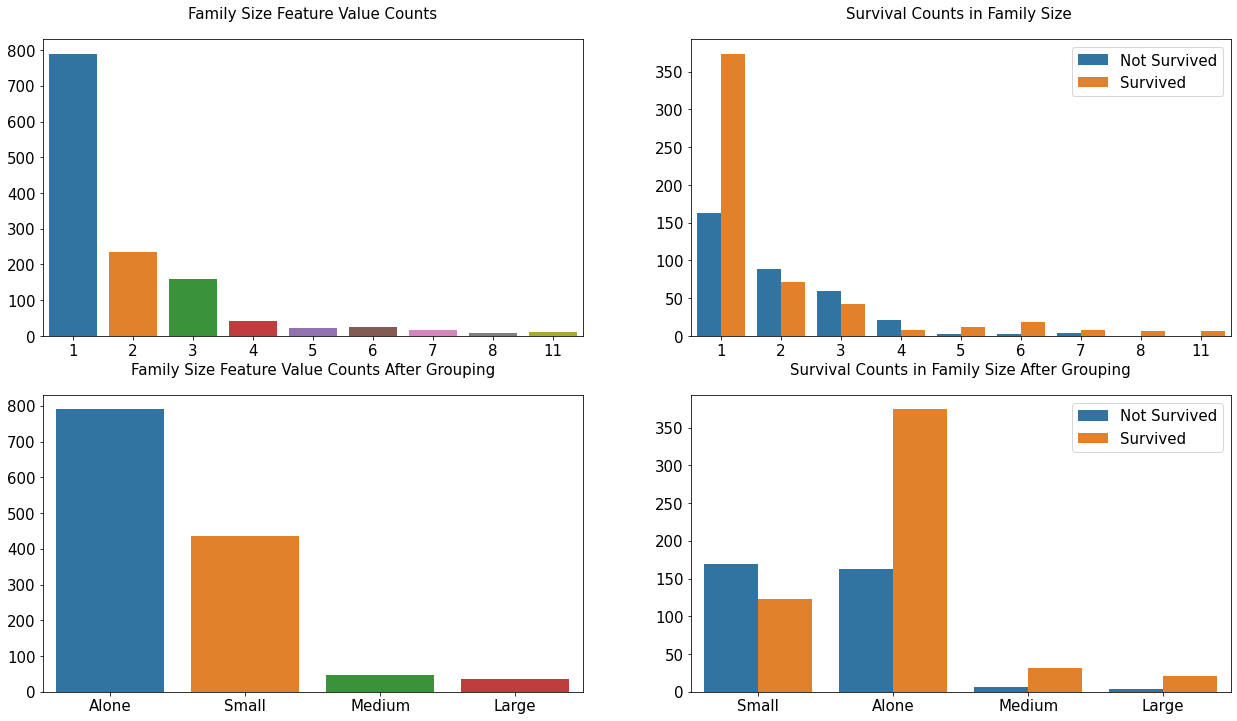

In [25]:
fig, axs = plt.subplots(figsize=(12, 12), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df['Family_Size'].value_counts().index, y=df['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=15, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=15, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df['Family_Category'] = df['Family_Size'].map(family_map)

sns.barplot(x=df['Family_Category'].value_counts().index, y=df['Family_Category'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Category', hue='Survived', data=df, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=15, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=15, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=15)
        axs[i][j].tick_params(axis='y', labelsize=15)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

#### Ticket

チケットの種類の把握

In [26]:
df.Ticket.value_counts()

CA. 2343             11
1601                  8
CA 2144               8
3101295               7
PC 17608              7
                     ..
345767                1
2693                  1
382653                1
65303                 1
STON/O 2. 3101292     1
Name: Ticket, Length: 929, dtype: int64

In [27]:
df['Ticket_Freqency'] = df['Ticket'].map(df.Ticket.value_counts())  # pd.seriesでもmap使えるのね！

In [28]:
# Ticket_Freqency と Family_Size の相関係数
df['Ticket_Freqency'].corr(df['Family_Size'])
# Groupの項を参照

0.8005555454053294

Ticket の数字部分に着目して分類する

In [29]:
# 数字部分の抽出
df['Ticket_Number'] = 0
for i in range(len(df)):  # pandas.series のままだと、[i]のアクセスがうまくいかなかった -> ()つければいける
    if df['Ticket'].values[i] == 'LINE': # 調べたら４個あった
        df['Ticket_Number'][i] = 0
    else:
        df['Ticket_Number'][i] = str(df['Ticket'].values[i]).split()[-1] # strにしないとsplit使えなくなった...
                           
df['Ticket_Number'] = pd.Series(df['Ticket_Number']).astype(np.int64)

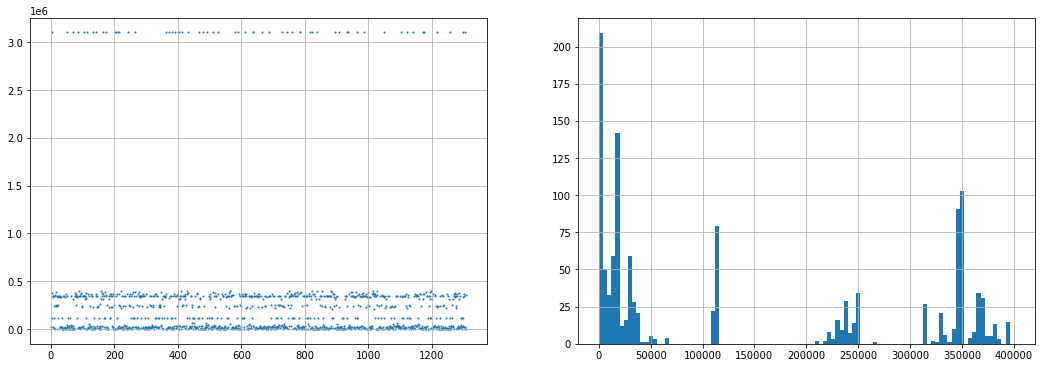

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharex=False)

# 番号の散布図
axes[0].scatter(range(len(df)), df['Ticket_Number'], s=1)
axes[0].grid(True)

# ヒストグラム
axes[1].hist(x=df['Ticket_Number'], bins=100, range=(0,400000))
axes[1].grid(True)
plt.show()

In [31]:
# ヒストグラムから目視で分割
df['Ticket_map'] = 0
for i in range(len(df)):
    if (df['Ticket_Number'][i] > 80000) & (df['Ticket_Number'][i] < 150000):
        df['Ticket_map'][i] = 1
    elif (df['Ticket_Number'][i] > 150000) & (df['Ticket_Number'][i] < 300000):
        df['Ticket_map'][i] = 2
    elif (df['Ticket_Number'][i] > 300000) & (df['Ticket_Number'][i] < 400000):
        df['Ticket_map'][i] = 3
    elif df['Ticket_Number'][i] > 2000000:
        df['Ticket_map'][i] = 4 

#### Group

In [32]:
# Ticket_Freqency と Family_Size の相関係数
df['Ticket_Freqency'].corr(df['Family_Size'])

0.8005555454053294

相関係数が高すぎて新しい示唆は得られそうにないため、これらを合わせて Group として新しい特徴量を作りたい！
　　　　　➡「ラストネームとチケットの種類が同じ」 or 「同じチケット」　の場合を同じグループとみなす
     
（https://qiita.com/FukuharaYohei/items/c87f61aee2a24466d5d4　の素晴らしいアイデアを参考にした）

In [33]:
# Last Name作成
df['Last_Name'] = df['Name'].apply(lambda x: str.split(x, ",")[0])

# FareがNullのレコードは文字列"nan"となる
df['Name_Fare'] = df['Last_Name'] + df['Fare'].astype('str')

In [34]:
# 姓とFareでグルーピング
def process_name(i, name_fare):
    tickets = df.loc[(df['Name_Fare'] == name_fare) & (df['Group'].isnull()),'Ticket'].unique().tolist()
    df.loc[(df['Name_Fare'] == name_fare) & (df['Group'].isnull()), 'Group'] = int(i)
    for ticket in tickets:
        process_ticket(i, ticket)

# チケットでグルーピング        
def process_ticket(i, ticket):
    name_fares = df.loc[(df['Ticket'] == ticket) & (df['Group'].isnull()),'Name_Fare'].unique().tolist()
    df.loc[(df['Ticket'] == ticket) & (df['Group'].isnull()), 'Group'] = int(i)
    for name_fare in name_fares:
        process_name(i, name_fare)

df['Group'] = None

# チケットでグルーピング(再帰処理で姓とFare、チケットでのグルーピングを繰り返す)
[process_ticket(i, ticket) for i, ticket in enumerate(df['Ticket'].unique().tolist())]

df['Group'] = df['Group'].astype(np.int64)

print('Ticket Count', df['Ticket'].nunique())
print('Name & Fare Count', df['Name_Fare'].nunique())
print('Ticket & Name Count', df['Group'].nunique())

Ticket Count 929
Name & Fare Count 982
Ticket & Name Count 887


### エンコーディング

In [35]:
# Sex
df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

In [36]:
# 残りはまとめてone-hot-endofing
encoding_list = ['Title', 'Embarked', 'Family_Category']

for i in encoding_list:
    ohe = pd.get_dummies(df[i]).astype(np.int64)
    ohe = ohe[:]
    df = pd.concat([df, ohe], axis=1)

In [37]:
pd.set_option('display.max_columns', 200)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsCabin,Title,Family_Size,Family_Category,Ticket_Freqency,Ticket_Number,Ticket_map,Last_Name,Name_Fare,Group,Master,Miss,Mr,Mrs,Other,C,Q,S,Alone,Large,Medium,Small
0,1,1.0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,A/5 21171,7.2500,NaN,S,1,Mr,2,Small,1,21171,0,Braund,Braund7.25,0,0,0,1,0,0,0,0,1,0,0,0,1
1,2,0.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,PC 17599,71.2833,C,C,0,Mrs,2,Small,2,17599,0,Cumings,Cumings71.2833,1,0,0,0,1,0,1,0,0,0,0,0,1
2,3,0.0,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss,1,Alone,1,3101282,4,Heikkinen,Heikkinen7.925,2,0,1,0,0,0,0,0,1,1,0,0,0
3,4,0.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803,53.1000,C,S,0,Mrs,2,Small,2,113803,1,Futrelle,Futrelle53.1,3,0,0,0,1,0,0,0,1,0,0,0,1
4,5,1.0,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450,8.0500,NaN,S,1,Mr,1,Alone,1,373450,3,Allen,Allen8.05,4,0,0,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,32.252151,0,0,A.5. 3236,8.0500,NaN,S,1,Mr,1,Alone,1,3236,0,Spector,Spector8.05,926,0,0,1,0,0,0,0,1,1,0,0,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.000000,0,0,PC 17758,108.9000,C,C,0,Other,1,Alone,3,17758,0,Oliva y Ocana,Oliva y Ocana108.9,273,0,0,0,0,1,1,0,0,1,0,0,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,Mr,1,Alone,1,3101262,4,Saether,Saether7.25,927,0,0,1,0,0,0,0,1,1,0,0,0
1307,1308,NaN,3,"Ware, Mr. Frederick",0,32.252151,0,0,359309,8.0500,NaN,S,1,Mr,1,Alone,1,359309,3,Ware,Ware8.05,928,0,0,1,0,0,0,0,1,1,0,0,0


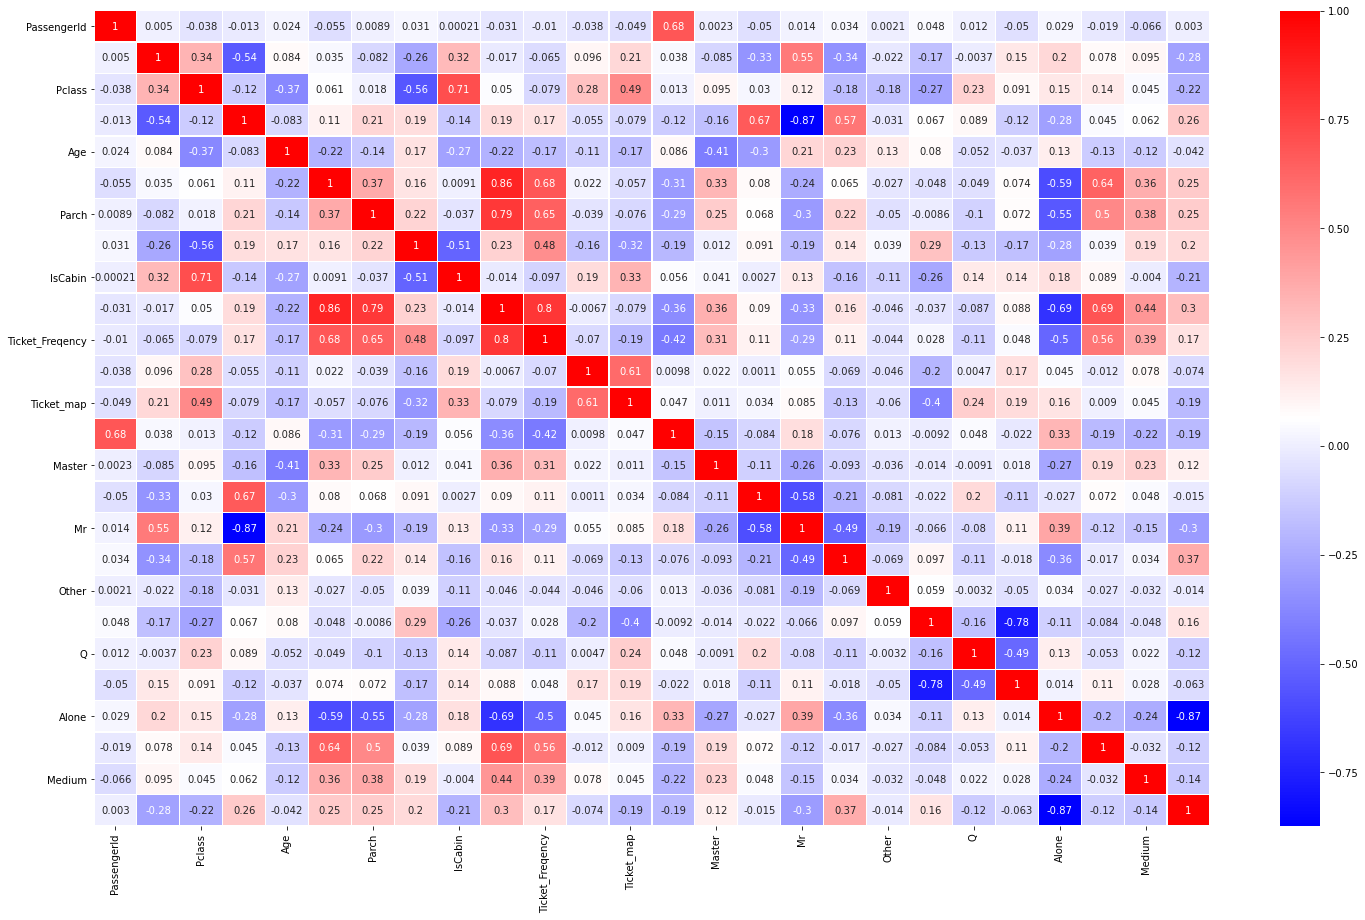

In [38]:
sns.heatmap(df.corr(),annot=True,cmap='bwr',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(25,15)
plt.show()

# なんでカラム名表示されないんだああ

## modeling

In [39]:
df2 = df.copy()
drop_list = ['PassengerId', 'Name', 'Ticket', 'Title', 'Cabin', 'Family_Category', 'Last_Name', 'Name_Fare', 'Embarked', 'Ticket_Number']

for i in drop_list:
    df2.drop(i, axis=1, inplace=True)

In [40]:
df2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,IsCabin,Family_Size,Ticket_Freqency,Ticket_map,Group,Master,Miss,Mr,Mrs,Other,C,Q,S,Alone,Large,Medium,Small
0,1.0,3,0,22.000000,1,0,7.2500,1,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1,0.0,1,1,38.000000,1,0,71.2833,0,2,2,0,1,0,0,0,1,0,1,0,0,0,0,0,1
2,0.0,3,1,26.000000,0,0,7.9250,1,1,1,4,2,0,1,0,0,0,0,0,1,1,0,0,0
3,0.0,1,1,35.000000,1,0,53.1000,0,2,2,1,3,0,0,0,1,0,0,0,1,0,0,0,1
4,1.0,3,0,35.000000,0,0,8.0500,1,1,1,3,4,0,0,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,0,32.252151,0,0,8.0500,1,1,1,0,926,0,0,1,0,0,0,0,1,1,0,0,0
1305,NaN,1,1,39.000000,0,0,108.9000,0,1,3,0,273,0,0,0,0,1,1,0,0,1,0,0,0
1306,NaN,3,0,38.500000,0,0,7.2500,1,1,1,4,927,0,0,1,0,0,0,0,1,1,0,0,0
1307,NaN,3,0,32.252151,0,0,8.0500,1,1,1,3,928,0,0,1,0,0,0,0,1,1,0,0,0


In [41]:
# 説明変数、目的変数の設定
X = df2.iloc[:len(df_train), 1:].values
y = df2.iloc[:len(df_train), 0].values
X_test = df2.iloc[len(df_train):, 1:].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

In [42]:
#標準化　モデルによってはしなくてok
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)

### ランダムフォレストのハイパーパラメータ調整

from https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial

In [43]:
# %%time
# #条件設定
# max_score = 0
# SearchMethod = 0
# RFC_grid = {RandomForestClassifier(): {"n_estimators" : [i for i in range(1, 21)],
#                                        "criterion" : ["gini", "entropy"],
#                                        "max_depth" :[i for i in range(1, 5)],
#                                        'min_samples_leaf' : [i for i in range(1, 10)],
#                                        "random_state" : [42],
#                                       }}

# #ランダムフォレストの実行
# for model, param in tqdm(RFC_grid.items()):
#     clf = GridSearchCV(model, param)
#     clf.fit(X_train_std, y_train)
#     y_pred = clf.predict(X_valid_std)
#     score = f1_score(y_valid, y_pred, average="micro")

#     if max_score < score:
#         max_score = score
#         best_param = clf.best_params_
#         best_model = model.__class__.__name__

# print("ベストスコア:{}".format(max_score))
# print("モデル:{}".format(best_model))
# print("パラメーター:{}".format(best_param))

# #ハイパーパラメータを調整しない場合との比較
# model = RandomForestClassifier()
# model.fit(X_train, y_train)
# score = model.score(X_valid, y_valid)
# print("")
# print("デフォルトスコア:", score)

### 様々なモデルの比較

In [44]:
# ランダムフォレスト
rfc = RandomForestClassifier(criterion='gini', max_depth=4, min_samples_leaf=3, n_estimators=9, n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)
acc_rfc = round(rfc.score(X_train, y_train), 3)
acc_rfc2 = round(rfc.score(X_valid, y_valid), 3)
                
# decision tree
dec = DecisionTreeClassifier(max_depth=3, random_state=42)
dec.fit(X_train_std, y_train)
acc_dec = round(dec.score(X_train_std, y_train), 3)
acc_dec2 = round(dec.score(X_valid_std, y_valid), 3)

# support vector
svc = SVC()
svc.fit(X_train_std, y_train)
acc_svc = round(svc.score(X_train_std, y_train), 3)
acc_svc2 = round(svc.score(X_valid_std, y_valid), 3)

# k近傍法
knn = KNeighborsClassifier(n_neighbors = 23)
knn.fit(X_train_std, y_train)
acc_knn = round(knn.score(X_train_std, y_train), 3)
acc_knn2 = round(knn.score(X_valid_std, y_valid), 3)

# ロジスティック回帰
lr = LogisticRegression(random_state=42)
lr.fit(X_train_std, y_train)
acc_lr = round(lr.score(X_train_std, y_train), 3)
acc_lr2 = round(lr.score(X_valid_std, y_valid), 3)

# パーセプトロン
pc = Perceptron()
pc.fit(X_train_std, y_train)
acc_pc = round(pc.score(X_train_std, y_train), 3)
acc_pc2 = round(pc.score(X_valid_std, y_valid), 3)

# 多層パーセプトロン
mlpc = MLPClassifier(hidden_layer_sizes=(16, 5, 6), random_state=0)
mlpc.fit(X_train_std, y_train)
acc_mlpc = round(mlpc.score(X_train_std, y_train), 3)
acc_mlpc2 = round(mlpc.score(X_valid_std, y_valid), 3)

# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train_std, y_train)
acc_gnb = round(gnb.score(X_train_std, y_train), 3)
acc_gnb2 = round(gnb.score(X_valid_std, y_valid), 3)

# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(X_train_std, y_train)
acc_sgd = round(sgd.score(X_train_std, y_train), 3)
acc_sgd2 = round(sgd.score(X_valid_std, y_valid), 3)

# データフレームにして比較
models = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'Support Vector Machines', 'KNN', 'Logistic Regression', 
              'perceptron', 'Multilayer perceptron', 'Gaussian Naive Bayes', 'Stochastic Gradient Descent'],
    'Train_Score': [acc_rfc, acc_dec, acc_svc, acc_knn, acc_lr, acc_pc, acc_mlpc, acc_gnb, acc_sgd],
    'Test_Score': [acc_rfc2, acc_dec2, acc_svc2, acc_knn2, acc_lr2, acc_pc2, acc_mlpc2, acc_gnb2, acc_sgd2],
                        })
models.sort_values(by='Test_Score', ascending=False)

,Model,Train_Score,Test_Score
2,Support Vector Machines,0.831,0.857
4,Logistic Regression,0.811,0.845
0,Random Forest,0.829,0.830
1,Decision Tree,0.818,0.816
5,perceptron,0.787,0.798
6,Multilayer perceptron,0.858,0.794
7,Gaussian Naive Bayes,0.796,0.794
3,KNN,0.787,0.785
8,Stochastic Gradient Descent,0.780,0.771


In [45]:
# # csvファイルに出力
# y_pred = rfc.predict(X_test)
# submission = pd.read_csv(path + 'gender_submission.csv')
# submission['Survived'] = y_pred.astype(int)
# submission.to_csv('C:/Users/Victor/Documents/my_study/Kaggle/Titanic/submission/submission_rfc8.csv', index=False)

In [46]:
# csvファイルに出力 （GCI）
y_pred = rfc.predict(X_test)
submission_gci = pd.read_csv(path + 'gender_submission.csv')
submission_gci['Perished'] = y_pred.astype(int)
submission_gci.to_csv('C:/Users/Victor/Documents/my_study/GCI/コンペ1/submission_rfc33.csv', index=False)

# svc 0.788
# rfc 0.803